In [1]:
import os
import pprint
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

import data
import networks as net

from networks import Generator, Discriminator
from torch.utils.data import DataLoader

torch.manual_seed(0)

plt.rcParams['image.cmap'] = 'Blues_r'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [3]:
# import os
# labs = os.listdir('./data/google_digit_data/test/labels')
# max_len = -1
# for i in labs:
#     with open(f'./data/google_digit_data/test/labels/{i}','r') as f:
#         cls_num = len(f.read().split('\n')[:-1])
#         if cls_num > max_len:
#             max_len = cls_num

## confirmed that max_len is 5

In [4]:
hp_dict = {
    'run_name': 'GANs_training_google12',
    'description': 'GANS google images training',
    
    'image_size': (3, 32, 32),
    
    'batch_size': 16,
    'num_epochs': 80,
    
    'learning_rate_discr': 0.01,
    'learning_rate_gen': 0.01,
    'discr_iters': 1,
    'gen_iters': 4,
    
    'alpha': 1,
    'beta': 10,
    'threshold': 0.3,
}

# extract all hyperparameters for ease of use
run_name = hp_dict['run_name']
C, M, N = hp_dict['image_size']

batch_size = hp_dict['batch_size']
num_epochs = hp_dict['num_epochs']

learning_rate_discr = hp_dict['learning_rate_discr']
learning_rate_gen = hp_dict['learning_rate_gen']
discr_iters = hp_dict['discr_iters']
gen_iters = hp_dict['gen_iters']

alpha = hp_dict['alpha']
beta = hp_dict['beta']
threshold = hp_dict['threshold']

In [5]:
# create output directory for this training session
try:
    os.mkdir(f'GANs_training/{run_name}')
except FileExistsError:
    shutil.rmtree(f'GANs_training/{run_name}')
    os.mkdir(f'GANs_training/{run_name}')

In [6]:
# record hyperparameters
hp_dict_str = pprint.pformat(hp_dict)

with open(f'GANs_training/{run_name}/hp_dict', 'wb+') as f:
    pkl.dump(hp_dict, f)

with open(f'GANs_training/{run_name}/hp_dict.txt', 'w+') as f:
    f.write(hp_dict_str)

In [7]:
# create dataset
dataset = data.GANs_Dataset(data_dir='./gans_data/data_google_large') # _large is subset taken from training data
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

1000
tensor([[[144., 140., 140.,  ..., 135., 134., 130.],
         [140., 144., 140.,  ..., 145., 140., 135.],
         [138., 141., 139.,  ..., 148., 145., 138.],
         ...,
         [142., 140., 140.,  ..., 136., 136., 136.],
         [147., 145., 145.,  ..., 143., 143., 143.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[187., 183., 183.,  ..., 177., 178., 177.],
         [183., 187., 183.,  ..., 186., 182., 179.],
         [184., 184., 182.,  ..., 184., 183., 178.],
         ...,
         [184., 181., 182.,  ..., 176., 177., 177.],
         [178., 176., 176.,  ..., 173., 173., 173.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[178., 176., 176.,  ..., 163., 161., 159.],
         [174., 180., 176.,  ..., 172., 168., 164.],
         [174., 175., 173.,  ..., 174., 172., 167.],
         ...,
         [174., 173., 172.,  ..., 165., 163., 163.],
         [172., 170., 168.,  ..., 165., 163., 163.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   

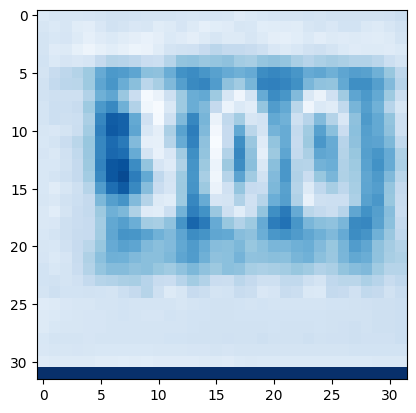

In [8]:
print(len(dataset))
print(dataset.image_list[0])
print(dataset.image_list[0].shape)
plt.imshow(dataset.image_list[0][0].numpy())
plt.show()

In [ ]:
def hinge_loss(gen_perturb):    
    return torch.sum(torch.clip(torch.linalg.norm(gen_perturb.reshape(gen_perturb.shape[0], 3, M * N), dim=(-1, -2)) - threshold, min=0)) / batch_size

In [10]:
# set up models
discr_model = Discriminator().double()
gen_model = Generator().double()

discr_model.to(device)
gen_model.to(device)

# target_model = # YOLO Model

# record model architectures
with open(f'GANs_training/{run_name}/discriminator_architecture_summary.txt', 'w+') as f:
    f.write(str(discr_model))
    
with open(f'GANs_training/{run_name}/generator_architecture_summary.txt', 'w+') as f:
    f.write(str(gen_model))
    
# record training log
with open(f'GANs_training/{run_name}/training_log.txt', 'w+') as f:
    f.write("Model training log created")

In [11]:
# set up trained YOLO model

from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_google_data_32.yaml') 
trainer.setup_model()
trainer.model.double()
trainer.set_model_attributes()
trainer.model = trainer.model.to(device)

Ultralytics YOLOv8.0.94 🚀 Python-3.7.5 torch-1.13.1+cu117 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=predict, model=./model_results/model_google_data_32/best.pt, data=./model_results/model_google_data_32/data_google_path.yaml, epochs=100, patience=50, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, k

In [12]:
# track metrics
loss_discr_list = []
loss_gen_list = []

loss_discr_by_epoch_list = []
loss_gen_by_epoch_list = []

In [13]:
# set up or refresh optimizers
optimizer_discr = torch.optim.Adam(discr_model.parameters(), lr=learning_rate_discr, amsgrad=True)
optimizer_gen = torch.optim.Adam(gen_model.parameters(), lr=learning_rate_gen, amsgrad=True)

In [14]:
# train
discr_model.train().cuda()
gen_model.train().cuda()
trainer.model.eval().cuda()

overall_time_epoch = []
gen_time_epoch = []
discr_time_epoch = []
yolo_time_epoch = []


for epoch in range(num_epochs):
    
    epoch_start = time.monotonic()
    discr_loss_epoch, gen_loss_epoch = 0, 0
    
    discr_time, gen_time, yolo_time = 0, 0, 0
    
    for batch_id, (images, classes, annotations) in enumerate(dataset_loader):
        images = images.double()
        classes = classes.double()
        annotations = annotations.double()
        
        tensor_img = images.repeat(1,1,1,1)
        classes = torch.flatten(classes, end_dim=1)
#         for i in range(len(classes)):
#             classes[i] = 8
        annotations = torch.flatten(annotations, end_dim=1)
#         print(tensor_img.shape)
        
        batch_idx = []
        keep_indices = []
        batch_i = 0
        for i, cls in enumerate(classes):
            if cls.item() != -1:
                keep_indices.append(i)
                batch_idx.append(batch_i)
                
            if (cls.item() == -1 and batch_idx[-1] == batch_i) or (i + 1) % 5 == 0:
                batch_i += 1
                
        classes = classes[keep_indices]
        annotations = annotations[keep_indices]
        batch_idx = torch.tensor(batch_idx)
        
        tensor_img = tensor_img.to(device)
        classes = classes.to(device)
        annotations = annotations.to(device)
        batch_idx = batch_idx.to(device)
            
        discr_loss, gen_loss = 0, 0
        
        for discr_i in range(discr_iters):
            
            ## start discriminator time
            discr_time_start = time.monotonic()
            
            gen_perturb = gen_model(tensor_img)
            images_perturb = tensor_img + gen_perturb
            
            loss_discr = net.compute_discr_loss_minimax(discr_model, tensor_img, images_perturb)
            
            optimizer_discr.zero_grad()
            loss_discr.backward()
            optimizer_discr.step()
            
            discr_loss += loss_discr.item()
            discr_loss_epoch += loss_discr.item()
            
            ## end discriminator time
            discr_time_end = time.monotonic()
            discr_time += (discr_time_end-discr_time_start) # add to discr time for this epoch

        loss_discr_list.append(discr_loss / discr_iters)

        for gen_i in range(gen_iters):
            
            ## start generator time
            gen_time_start = time.monotonic()
            gen_perturb = gen_model(tensor_img)
            images_perturb = tensor_img + gen_perturb
            
            tensor_img_resized = resize_right.resize(images_perturb, out_shape=(batch_size,3,32,32))

#             batch = {'ori_shape': ((3, 32, 32) for _ in range(batch_size)),
#                 'ratio_pad': None,
#                 'im_file': None,
#                 'img': tensor_img_resized,
#                 'cls': classes,
#                 'bboxes': annotations,
#                 'batch_idx': batch_idx
#             }
            batch = {'ori_shape': ((3, 32, 32) for _ in range(batch_size)),
                'ratio_pad': None,
                'im_file': None,
                'img': tensor_img_resized,
                'cls': torch.tensor([]),
                'bboxes': torch.tensor([]),
                'batch_idx': torch.tensor([])
            }

            ## start YOLO time
            yolo_time_start = time.monotonic()
            yolo_out = trainer.model(tensor_img_resized)            
            loss_fn = Loss(trainer.model)
            
            ## end YOLO time
            yolo_time_end = time.monotonic()
            yolo_time += (yolo_time_end-yolo_time_start)
            
            loss_adv, _ = loss_fn(yolo_out, batch)
            loss_adv *= 1 / batch_size
            
            loss_gan = net.compute_gen_loss_minimax_modified(discr_model, images_perturb)
            loss_hinge = hinge_loss(gen_perturb)
            loss_gen = loss_adv + alpha * loss_gan + beta * loss_hinge
            
            gen_model.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            
            gen_loss += loss_gen.item()
            gen_loss_epoch += loss_gen.item()
            
            ## end generator time
            gen_time_end = time.monotonic()
            gen_time += (gen_time_end-gen_time_start)
            

        loss_gen_list.append(gen_loss / gen_iters)
                
        if batch_id % 2 == 0:
            print('---------------------------------------------------------------------------------------------------------------------')
            print(f'epoch: {epoch}; batch: {batch_id}; discr loss: {discr_loss / discr_iters}; gen loss: {gen_loss / gen_iters}')
#             print(f'epoch: {epoch}; batch: {batch_id};')
            print(f'adv loss: {loss_adv}; gan loss: {loss_gan}; hinge loss: {loss_hinge}; (from last batch)')
            with open(f'GANs_training/{run_name}/training_log.txt', 'a') as f:
                f.write('---------------------------------------------------------------------------------------------------------------------')
                f.write(f'epoch: {epoch}; batch: {batch_id}; discr loss: {discr_loss / discr_iters}; gen loss: {gen_loss / gen_iters}')
#                 f.write(f'epoch: {epoch}; batch: {batch_id};')
                f.write(f'adv loss: {loss_adv}; gan loss: {loss_gan}; hinge loss: {loss_hinge}; (from last batch)')                
                f.close()

    ## end epoch time        
    epoch_end = time.monotonic()
    
    ## save training time
    overall_time_epoch.append(epoch_end - epoch_start)
    discr_time_epoch.append(discr_time)
    gen_time_epoch.append(gen_time)
    yolo_time_epoch.append(yolo_time)
        
    loss_discr_by_epoch_list.append(discr_loss_epoch / len(dataset_loader) / discr_iters)
    loss_gen_by_epoch_list.append(gen_loss_epoch / len(dataset_loader) / gen_iters)

---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 0; discr loss: 1.40186629408718; gen loss: 632.4604564213679
adv loss: 11.739235877990723; gan loss: 0.7210338298651287; hinge loss: 43.34654073211033; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 2; discr loss: 1.3546368306713314; gen loss: 161.38196607917504
adv loss: 15.072563171386719; gan loss: 0.554217917088937; hinge loss: 13.350736771480218; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 4; discr loss: 1.5485171355626253; gen loss: 94.47593462309293
adv loss: 18.351741790771484; gan loss: 0.5034445304896963; hinge loss: 5.379750228183279; (from last batch)
--------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 54; discr loss: 1.0114776107704824; gen loss: 35.30601968962513
adv loss: 13.97061538696289; gan loss: 1.1547266940465066; hinge loss: 1.9671481617697624; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 56; discr loss: 2.1145254498568473; gen loss: 31.19414155980415
adv loss: 11.430704116821289; gan loss: 1.452957823468045; hinge loss: 1.7688342123490886; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 0; batch: 58; discr loss: 4.472132858538859; gen loss: 37.2615332713
adv loss: 18.082239151000977; gan loss: 0.40243075171386733; hinge loss: 1.6674134226572819; (from last batch)
-------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 1; batch: 44; discr loss: 0.952324021753205; gen loss: 32.625937988832554
adv loss: 14.870964050292969; gan loss: 0.8918443357925031; hinge loss: 1.5374019539415555; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 1; batch: 46; discr loss: 0.9241208164785395; gen loss: 29.859190651814508
adv loss: 12.89306926727295; gan loss: 1.5338292435442615; hinge loss: 1.4293293021715328; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 1; batch: 48; discr loss: 1.140119729929755; gen loss: 32.589460905838386
adv loss: 10.823591232299805; gan loss: 2.1780315567155237; hinge loss: 1.8199306350465525; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 2; batch: 34; discr loss: 1.086593618313583; gen loss: 27.629576520799947
adv loss: 11.501167297363281; gan loss: 0.8778143031711072; hinge loss: 1.4872838053029112; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 2; batch: 36; discr loss: 1.127967573130019; gen loss: 27.292566146467067
adv loss: 14.222259521484375; gan loss: 0.9509755906369695; hinge loss: 1.1555840375228021; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 2; batch: 38; discr loss: 1.1823392103892025; gen loss: 30.821443064169326
adv loss: 13.258062362670898; gan loss: 1.0667147927079483; hinge loss: 1.5766936996285987; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 3; batch: 24; discr loss: 1.6296956729888181; gen loss: 26.250205721756842
adv loss: 9.740364074707031; gan loss: 1.389094540008648; hinge loss: 1.4341557873274822; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 3; batch: 26; discr loss: 1.4779915038069162; gen loss: 27.732200884863026
adv loss: 13.227765083312988; gan loss: 1.2017749667975646; hinge loss: 1.2027913752604706; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 3; batch: 28; discr loss: 1.355570822449483; gen loss: 24.364507840365818
adv loss: 10.013069152832031; gan loss: 1.0102207500624416; hinge loss: 1.3032940007835085; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 4; batch: 14; discr loss: 1.7138053985318489; gen loss: 24.2805914561179
adv loss: 9.653099060058594; gan loss: 1.122677548296796; hinge loss: 1.2733744542965506; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 4; batch: 16; discr loss: 1.4906603206406674; gen loss: 21.191637263988305
adv loss: 7.71127986907959; gan loss: 1.3766581639944033; hinge loss: 1.1856607243245074; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 4; batch: 18; discr loss: 1.4881084517032839; gen loss: 24.605025724992743
adv loss: 8.996538162231445; gan loss: 1.0099935930225616; hinge loss: 1.3838371779383651; (from last batch)
-----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 4; discr loss: 1.3792130140730994; gen loss: 23.53415657204424
adv loss: 9.844690322875977; gan loss: 1.092283674920738; hinge loss: 1.1969947933185214; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 6; discr loss: 1.7528025214137908; gen loss: 21.78113999807196
adv loss: 10.048100471496582; gan loss: 0.8096215636717476; hinge loss: 1.0326634634593201; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 8; discr loss: 1.0565681985256317; gen loss: 23.971617570705924
adv loss: 10.994552612304688; gan loss: 0.9791803783135631; hinge loss: 1.142799037562742; (from last batch)
------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 58; discr loss: 0.8886217899608809; gen loss: 17.73744998493697
adv loss: 6.779021739959717; gan loss: 0.9289945543944662; hinge loss: 0.980701431778544; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 60; discr loss: 1.0977710050667153; gen loss: 21.238062343678703
adv loss: 7.980987071990967; gan loss: 0.8153072877778897; hinge loss: 1.1552063801412538; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 5; batch: 62; discr loss: 1.137908864967725; gen loss: 17.922649470897376
adv loss: 7.593325614929199; gan loss: 2.4169297950983855; hinge loss: 0.6832372907027235; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 6; batch: 48; discr loss: 0.6813251237690976; gen loss: 20.558214187894748
adv loss: 7.357632637023926; gan loss: 1.5315122248332718; hinge loss: 1.0944546616392112; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 6; batch: 50; discr loss: 0.6964327545617484; gen loss: 22.678198817157828
adv loss: 9.521866798400879; gan loss: 1.3447306584015764; hinge loss: 1.1248332729367698; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 6; batch: 52; discr loss: 0.8441139950060297; gen loss: 21.975311575639815
adv loss: 7.467946529388428; gan loss: 1.1671081903380212; hinge loss: 1.3010007022875159; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 7; batch: 38; discr loss: 0.8699936855980575; gen loss: 19.54481669717552
adv loss: 4.89849328994751; gan loss: 1.096074134250673; hinge loss: 1.3027308836564884; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 7; batch: 40; discr loss: 1.0522042516714039; gen loss: 17.58494588620372
adv loss: 5.81572961807251; gan loss: 1.0592422579415612; hinge loss: 1.001207833259114; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 7; batch: 42; discr loss: 1.1070990470807083; gen loss: 20.303877067745837
adv loss: 6.611963748931885; gan loss: 1.417244894481477; hinge loss: 1.115843554304051; (from last batch)
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 8; batch: 28; discr loss: 1.3472585947334463; gen loss: 19.82480133935193
adv loss: 6.970474720001221; gan loss: 0.8329193589202311; hinge loss: 1.148976789637913; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 8; batch: 30; discr loss: 1.1964970760417017; gen loss: 18.789907480753815
adv loss: 6.292012691497803; gan loss: 0.6399005762052266; hinge loss: 1.107237395356619; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 8; batch: 32; discr loss: 1.200917726236672; gen loss: 19.94379576891241
adv loss: 7.1073713302612305; gan loss: 0.8853509935045987; hinge loss: 1.1088743047953649; (from last batch)
-----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 9; batch: 18; discr loss: 1.4215722591743782; gen loss: 15.525160262996424
adv loss: 5.055416584014893; gan loss: 0.938643253506696; hinge loss: 0.9162323426254837; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 9; batch: 20; discr loss: 1.1717207264963987; gen loss: 18.70893808123154
adv loss: 5.738084316253662; gan loss: 1.250695720855507; hinge loss: 1.1191763289590622; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 9; batch: 22; discr loss: 1.1497887075768576; gen loss: 29.447340098855193
adv loss: 11.25849723815918; gan loss: 1.1642796702525031; hinge loss: 1.5484900618850996; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 10; batch: 8; discr loss: 1.4963848532154624; gen loss: 20.975067487703775
adv loss: 6.023549556732178; gan loss: 1.5045108923428239; hinge loss: 1.2783125561140523; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 10; batch: 10; discr loss: 1.0158667893250202; gen loss: 18.83224963813624
adv loss: 7.378591060638428; gan loss: 1.2668895979511121; hinge loss: 0.9492161593516288; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 10; batch: 12; discr loss: 1.0345602239136928; gen loss: 24.78331416846898
adv loss: 10.19704818725586; gan loss: 1.5198306216813267; hinge loss: 1.2114351755727648; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 10; batch: 62; discr loss: 1.2145139835489287; gen loss: 10.929986418460182
adv loss: 3.9893717765808105; gan loss: 0.6795732106392196; hinge loss: 0.5468076945836104; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 11; batch: 0; discr loss: 1.336962744550735; gen loss: 21.999535090822995
adv loss: 9.373699188232422; gan loss: 0.9550906496170408; hinge loss: 1.085294000680765; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 11; batch: 2; discr loss: 0.845260018917817; gen loss: 21.53387706439631
adv loss: 6.723134994506836; gan loss: 1.281316025254032; hinge loss: 1.256493118891831; (from last batch)
-----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 11; batch: 52; discr loss: 1.0474016498293173; gen loss: 16.773029921904133
adv loss: 6.145867347717285; gan loss: 0.867664868573849; hinge loss: 0.918380084716134; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 11; batch: 54; discr loss: 1.3858462105692042; gen loss: 17.119016025574084
adv loss: 4.32688045501709; gan loss: 1.2396911566025166; hinge loss: 1.083157638758163; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 11; batch: 56; discr loss: 1.1689343338898293; gen loss: 18.83282177771618
adv loss: 6.591268062591553; gan loss: 1.3859301318274349; hinge loss: 1.026315653553806; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 12; batch: 42; discr loss: 1.3551541463417478; gen loss: 19.317740793556297
adv loss: 6.088697910308838; gan loss: 0.7623572871039022; hinge loss: 1.1454234676394885; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 12; batch: 44; discr loss: 1.4520838903782594; gen loss: 17.536049106211852
adv loss: 6.7670183181762695; gan loss: 0.7031108685613454; hinge loss: 0.96447879277759; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 12; batch: 46; discr loss: 1.4453159801068942; gen loss: 18.50128821506905
adv loss: 6.951597690582275; gan loss: 1.096351999520147; hinge loss: 0.9500038814774303; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 13; batch: 32; discr loss: 0.6998769145878909; gen loss: 17.537946083595976
adv loss: 4.908544063568115; gan loss: 1.6017214299157003; hinge loss: 1.0694895372227071; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 13; batch: 34; discr loss: 1.1960476808609615; gen loss: 16.982734755852128
adv loss: 6.624492645263672; gan loss: 1.1290719176008723; hinge loss: 0.8787183006603229; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 13; batch: 36; discr loss: 1.1722879934002977; gen loss: 17.747626520546888
adv loss: 5.678190231323242; gan loss: 0.9225360468397865; hinge loss: 1.0375665494255988; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 14; batch: 22; discr loss: 1.232145030146882; gen loss: 15.96148587675867
adv loss: 4.945284366607666; gan loss: 1.0071627306978708; hinge loss: 0.9434822424932959; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 14; batch: 24; discr loss: 0.932542113508861; gen loss: 15.310421326890864
adv loss: 5.168965816497803; gan loss: 0.9797456892502304; hinge loss: 0.8797808132443403; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 14; batch: 26; discr loss: 1.1051275526402813; gen loss: 18.19301114444651
adv loss: 6.521596908569336; gan loss: 1.1113060566984612; hinge loss: 0.8860252059624072; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 15; batch: 12; discr loss: 0.8826129406120018; gen loss: 16.452827309046185
adv loss: 5.0856828689575195; gan loss: 1.1254789532269143; hinge loss: 0.9711801222026252; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 15; batch: 14; discr loss: 1.0417124696631999; gen loss: 16.475022904422083
adv loss: 5.878519058227539; gan loss: 0.835888455080589; hinge loss: 0.943857326670172; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 15; batch: 16; discr loss: 1.6000171786284578; gen loss: 16.639959634897608
adv loss: 7.070005893707275; gan loss: 0.900831432006659; hinge loss: 0.7998230193316085; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 2; discr loss: 0.7673753798832226; gen loss: 15.729126438176241
adv loss: 2.860771894454956; gan loss: 1.6223725117870818; hinge loss: 1.0221324893833508; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 4; discr loss: 1.2644141447910728; gen loss: 14.06467270041826
adv loss: 5.668477535247803; gan loss: 0.8618461152854874; hinge loss: 0.718116102986326; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 6; discr loss: 0.9944870776925501; gen loss: 17.774084825479164
adv loss: 4.3124470710754395; gan loss: 1.7717377324637649; hinge loss: 1.1729558851198432; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 56; discr loss: 1.3998712543552336; gen loss: 17.641899255017293
adv loss: 6.366600036621094; gan loss: 0.8947846861083968; hinge loss: 0.9763229386512495; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 58; discr loss: 0.7684782712757504; gen loss: 17.891829823905372
adv loss: 5.970085144042969; gan loss: 1.290735878958685; hinge loss: 0.9842624578784921; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 16; batch: 60; discr loss: 1.1157199956716704; gen loss: 15.451849766606006
adv loss: 5.13564920425415; gan loss: 0.6011836448911705; hinge loss: 0.9280233641945921; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 17; batch: 46; discr loss: 1.1781894406459894; gen loss: 15.602662448919038
adv loss: 5.471771240234375; gan loss: 1.158349025811702; hinge loss: 0.8137733536391112; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 17; batch: 48; discr loss: 1.0147048058074128; gen loss: 16.438866229117668
adv loss: 5.454665660858154; gan loss: 1.387212603864692; hinge loss: 0.9209117109952096; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 17; batch: 50; discr loss: 1.1206130384999222; gen loss: 17.889676464376976
adv loss: 7.213141441345215; gan loss: 1.2028553117198957; hinge loss: 0.8983809006637598; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 18; batch: 36; discr loss: 1.4405304836800408; gen loss: 14.101633851488774
adv loss: 4.195620536804199; gan loss: 0.7508927945852597; hinge loss: 0.8962937972088781; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 18; batch: 38; discr loss: 0.8528806138982536; gen loss: 15.512414254254121
adv loss: 4.108512878417969; gan loss: 1.1887115747531871; hinge loss: 0.9645411053947734; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 18; batch: 40; discr loss: 1.0640801188425484; gen loss: 14.422422790274297
adv loss: 4.008204936981201; gan loss: 1.2021450772118571; hinge loss: 0.8473332295758631; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 19; batch: 26; discr loss: 1.0813281586527526; gen loss: 13.73587440666708
adv loss: 3.4404194355010986; gan loss: 1.010434234261122; hinge loss: 0.879787912132105; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 19; batch: 28; discr loss: 1.0970913047265212; gen loss: 14.779276358737922
adv loss: 5.124237537384033; gan loss: 1.3518486525230209; hinge loss: 0.7847402824299765; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 19; batch: 30; discr loss: 0.7095132243648262; gen loss: 14.957358881338752
adv loss: 4.274424076080322; gan loss: 1.4439878908820674; hinge loss: 0.9012806858076848; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 20; batch: 16; discr loss: 1.1949025059498786; gen loss: 14.744385946801867
adv loss: 4.045932292938232; gan loss: 0.8383593885685905; hinge loss: 0.9386333158528049; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 20; batch: 18; discr loss: 1.329783085853679; gen loss: 14.110135869614004
adv loss: 4.934430122375488; gan loss: 0.6331904670123175; hinge loss: 0.819814400518955; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 20; batch: 20; discr loss: 1.3820907752075553; gen loss: 15.547853606148141
adv loss: 4.441840171813965; gan loss: 1.1050521542253426; hinge loss: 0.9751461765441052; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 21; batch: 6; discr loss: 1.0428748412165103; gen loss: 14.782498665002862
adv loss: 6.004750728607178; gan loss: 0.8945137374404099; hinge loss: 0.7688803328924588; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 21; batch: 8; discr loss: 1.2242067339399434; gen loss: 18.09887572449153
adv loss: 5.679427146911621; gan loss: 0.9711496734887154; hinge loss: 0.9726918210868509; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 21; batch: 10; discr loss: 1.0206163009025204; gen loss: 14.76407338081647
adv loss: 3.7230710983276367; gan loss: 1.3418238905083073; hinge loss: 0.9124877232137474; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 21; batch: 60; discr loss: 1.1196064725950405; gen loss: 14.18399369025482
adv loss: 3.8736355304718018; gan loss: 1.3477380519844901; hinge loss: 0.8748211252175409; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 21; batch: 62; discr loss: 1.303590763649375; gen loss: 12.76451690859626
adv loss: 4.742939472198486; gan loss: 0.9125314066838337; hinge loss: 0.6322564183853283; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 22; batch: 0; discr loss: 0.9617571911487595; gen loss: 16.59891302529877
adv loss: 4.63111686706543; gan loss: 1.0547129196189309; hinge loss: 1.033963341924625; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 22; batch: 50; discr loss: 0.8565191517250186; gen loss: 15.277073776735445
adv loss: 5.759468078613281; gan loss: 0.9981124721142499; hinge loss: 0.8160366527930147; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 22; batch: 52; discr loss: 0.9415035109086072; gen loss: 13.068712046933175
adv loss: 3.2838058471679688; gan loss: 1.268510109202606; hinge loss: 0.8147604659747762; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 22; batch: 54; discr loss: 0.98364503225295; gen loss: 15.275511087135687
adv loss: 5.570052623748779; gan loss: 1.4914477139593463; hinge loss: 0.7666434986235444; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 23; batch: 40; discr loss: 0.9642559140150069; gen loss: 14.842380567645606
adv loss: 4.767373085021973; gan loss: 1.7612731820211205; hinge loss: 0.770026836822798; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 23; batch: 42; discr loss: 0.9481556109260988; gen loss: 15.174016090780377
adv loss: 4.208654403686523; gan loss: 1.3035264025097242; hinge loss: 0.9264844110284354; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 23; batch: 44; discr loss: 0.9677689075896014; gen loss: 15.08409270925565
adv loss: 4.075417518615723; gan loss: 1.3614387233296583; hinge loss: 0.923130568142061; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 24; batch: 30; discr loss: 1.4341156830288022; gen loss: 15.719356702632677
adv loss: 5.2921857833862305; gan loss: 0.7798959602088835; hinge loss: 0.8713209415137384; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 24; batch: 32; discr loss: 1.0230758082104694; gen loss: 15.394710523130694
adv loss: 3.22231125831604; gan loss: 1.5474484634978096; hinge loss: 0.9948678332816716; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 24; batch: 34; discr loss: 1.5275924665938874; gen loss: 13.910767665369388
adv loss: 5.411687850952148; gan loss: 0.8002819995870472; hinge loss: 0.7148053171999413; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 25; batch: 20; discr loss: 0.9613481279194902; gen loss: 15.283848486249486
adv loss: 4.196414470672607; gan loss: 1.4428007254121593; hinge loss: 0.9193250254229866; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 25; batch: 22; discr loss: 1.3645081030854476; gen loss: 15.432494367586896
adv loss: 5.248032093048096; gan loss: 1.4512984654660852; hinge loss: 0.8302084787387782; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 25; batch: 24; discr loss: 1.181061034389704; gen loss: 14.093692655252458
adv loss: 4.356000900268555; gan loss: 0.8868172310979018; hinge loss: 0.8563632754680011; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 26; batch: 10; discr loss: 1.3824100280314648; gen loss: 15.510715352402007
adv loss: 5.130376815795898; gan loss: 1.0201712769805766; hinge loss: 0.8806730471625919; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 26; batch: 12; discr loss: 1.0404765336563822; gen loss: 15.3484364960491
adv loss: 4.408505439758301; gan loss: 1.1864240922676776; hinge loss: 0.9192744341561383; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 26; batch: 14; discr loss: 0.9622800051251285; gen loss: 13.499088788885253
adv loss: 4.154291152954102; gan loss: 1.2216029359053426; hinge loss: 0.7723768276293119; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 0; discr loss: 0.8955389055756737; gen loss: 15.487058094130454
adv loss: 3.012064218521118; gan loss: 1.4550088868432676; hinge loss: 0.9535245498482691; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 2; discr loss: 1.312666010095697; gen loss: 14.361765857175294
adv loss: 5.504628658294678; gan loss: 0.7908609675872464; hinge loss: 0.7506422270107347; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 4; discr loss: 0.9784759041055222; gen loss: 15.20422615459645
adv loss: 3.61221981048584; gan loss: 2.37235073607751; hinge loss: 0.8784797550813256; (from last batch)
------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 54; discr loss: 1.0538792487600903; gen loss: 13.515508191942931
adv loss: 4.7033891677856445; gan loss: 1.0419219325321867; hinge loss: 0.7205596209844999; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 56; discr loss: 0.944276311653969; gen loss: 15.749483467127092
adv loss: 4.3893208503723145; gan loss: 1.7505448699765167; hinge loss: 0.9057874196587337; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 27; batch: 58; discr loss: 0.9475186918899825; gen loss: 14.274077324861953
adv loss: 5.1268229484558105; gan loss: 1.15572479187525; hinge loss: 0.7622450484502236; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 28; batch: 44; discr loss: 0.8143884677219431; gen loss: 15.349185830388096
adv loss: 4.905521392822266; gan loss: 1.5596452263912; hinge loss: 0.8215204026149846; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 28; batch: 46; discr loss: 0.8519192227787513; gen loss: 14.364441052505722
adv loss: 4.930693626403809; gan loss: 1.1671715109151526; hinge loss: 0.7802991672393658; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 28; batch: 48; discr loss: 0.8798131308988606; gen loss: 15.233559677217027
adv loss: 3.413499593734741; gan loss: 1.1631769956715965; hinge loss: 1.0319875048620872; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 29; batch: 34; discr loss: 1.0104183203764618; gen loss: 16.092009939877613
adv loss: 4.7112836837768555; gan loss: 1.2179645694018848; hinge loss: 0.9267080309002425; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 29; batch: 36; discr loss: 0.850861040801649; gen loss: 14.57318821169639
adv loss: 4.907723426818848; gan loss: 1.4666554748736806; hinge loss: 0.7570694185737535; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 29; batch: 38; discr loss: 0.9857612927848263; gen loss: 13.702293004859591
adv loss: 4.3802618980407715; gan loss: 1.5376537448647534; hinge loss: 0.7185027667757671; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 30; batch: 24; discr loss: 0.9999423159989884; gen loss: 13.347760200677317
adv loss: 3.968982696533203; gan loss: 1.3685534021054704; hinge loss: 0.7519224948828975; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 30; batch: 26; discr loss: 1.2608613258488583; gen loss: 16.042912749711
adv loss: 6.439670562744141; gan loss: 1.1271913710959212; hinge loss: 0.7700309369048348; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 30; batch: 28; discr loss: 1.2279694606751423; gen loss: 16.556253415771348
adv loss: 5.0285234451293945; gan loss: 0.9576659022082898; hinge loss: 0.9994377968735153; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 31; batch: 14; discr loss: 1.0448041878966627; gen loss: 21.288315936288292
adv loss: 5.890041351318359; gan loss: 2.8654612216851967; hinge loss: 1.1521613152092898; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 31; batch: 16; discr loss: 0.7370593167007321; gen loss: 18.32851006721328
adv loss: 6.180849552154541; gan loss: 1.168707680341448; hinge loss: 1.0031212121123039; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 31; batch: 18; discr loss: 0.7310603378858902; gen loss: 13.712068995685355
adv loss: 3.775130271911621; gan loss: 0.8393225562714388; hinge loss: 0.8326937654167226; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 4; discr loss: 0.9862058187016869; gen loss: 15.531101094534653
adv loss: 4.559381484985352; gan loss: 1.3127331867799243; hinge loss: 0.8996751490681281; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 6; discr loss: 1.1348259792032702; gen loss: 17.04111974352027
adv loss: 4.53300142288208; gan loss: 0.8737989376971669; hinge loss: 1.044456886432258; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 8; discr loss: 1.5481035262550877; gen loss: 15.58413434673868
adv loss: 4.467211723327637; gan loss: 1.3846830675385298; hinge loss: 0.9343312466025993; (from last batch)
-----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 58; discr loss: 0.8352940866059595; gen loss: 15.66636194514047
adv loss: 4.473372459411621; gan loss: 1.1532533717367428; hinge loss: 0.9324439681585832; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 60; discr loss: 1.3873644546077952; gen loss: 13.873183256798448
adv loss: 4.741076946258545; gan loss: 0.8360295639724037; hinge loss: 0.774283682804972; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 32; batch: 62; discr loss: 1.351009767190451; gen loss: 12.901531285882037
adv loss: 4.542523384094238; gan loss: 1.6503702759025967; hinge loss: 0.5287056726875956; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 33; batch: 48; discr loss: 1.3745080322481174; gen loss: 15.684872960225086
adv loss: 6.108784198760986; gan loss: 0.7658663304902952; hinge loss: 0.8233338941399436; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 33; batch: 50; discr loss: 1.2079610384312998; gen loss: 15.75532893873963
adv loss: 4.8703718185424805; gan loss: 0.8488096929634736; hinge loss: 0.9543222699159772; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 33; batch: 52; discr loss: 1.1015672906467875; gen loss: 14.039255603413729
adv loss: 5.3971052169799805; gan loss: 0.8121136403077294; hinge loss: 0.7343603391901387; (from last batch)
---------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 34; batch: 38; discr loss: 1.0219603899523815; gen loss: 14.403849364649998
adv loss: 5.222645282745361; gan loss: 1.3059236328635107; hinge loss: 0.7184967127310792; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 34; batch: 40; discr loss: 1.1399154001772946; gen loss: 13.763660086728112
adv loss: 3.941577672958374; gan loss: 1.0322131999998185; hinge loss: 0.8350470733390156; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 34; batch: 42; discr loss: 0.8669906489542005; gen loss: 15.766943587018465
adv loss: 5.911956310272217; gan loss: 1.0711248153639386; hinge loss: 0.8079076105839413; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 35; batch: 28; discr loss: 1.2795076442512476; gen loss: 13.95052312779763
adv loss: 4.27234411239624; gan loss: 1.0724637875371255; hinge loss: 0.8207236109458622; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 35; batch: 30; discr loss: 1.6163765073679226; gen loss: 13.604730101393264
adv loss: 4.804806232452393; gan loss: 0.8957171133132646; hinge loss: 0.7405622574770145; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 35; batch: 32; discr loss: 1.038198169748735; gen loss: 13.51324424886891
adv loss: 4.034119606018066; gan loss: 1.2876259729189607; hinge loss: 0.7784284974331064; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 36; batch: 18; discr loss: 1.2497445731024286; gen loss: 12.894338973435971
adv loss: 4.007801532745361; gan loss: 0.9126018555506998; hinge loss: 0.7591106758536041; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 36; batch: 20; discr loss: 1.4015301453672904; gen loss: 14.84466930836845
adv loss: 4.322871685028076; gan loss: 1.0875201607675635; hinge loss: 0.9332374917371181; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 36; batch: 22; discr loss: 1.0721311301081737; gen loss: 12.519436924303996
adv loss: 4.2422380447387695; gan loss: 0.6150229980391404; hinge loss: 0.7167573661638327; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 37; batch: 8; discr loss: 0.8582672325987587; gen loss: 16.975300209016957
adv loss: 5.633212566375732; gan loss: 1.2637266357801444; hinge loss: 0.8907704059710729; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 37; batch: 10; discr loss: 1.2436987294341355; gen loss: 14.628144412774265
adv loss: 5.19966459274292; gan loss: 1.4273298180167493; hinge loss: 0.7619790886393054; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 37; batch: 12; discr loss: 1.1161362674323487; gen loss: 12.684951470072596
adv loss: 4.207353115081787; gan loss: 1.0185221280962018; hinge loss: 0.7099607491861717; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 37; batch: 62; discr loss: 1.8166963054214151; gen loss: 9.762201005900438
adv loss: 4.047975063323975; gan loss: 0.6119975920721819; hinge loss: 0.414615697113383; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 38; batch: 0; discr loss: 1.1394870299360869; gen loss: 13.723010722355374
adv loss: 3.53700590133667; gan loss: 1.399260492185887; hinge loss: 0.860872060433608; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 38; batch: 2; discr loss: 1.2449836237715362; gen loss: 12.99492107543633
adv loss: 4.494160175323486; gan loss: 0.8109026004782884; hinge loss: 0.7292192390553965; (from last batch)
------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 38; batch: 52; discr loss: 1.3092765940373456; gen loss: 12.78632701452888
adv loss: 3.8298850059509277; gan loss: 1.273949746207327; hinge loss: 0.7259935762310686; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 38; batch: 54; discr loss: 0.8747873878949295; gen loss: 13.7003129610547
adv loss: 3.426908016204834; gan loss: 1.0552491265228605; hinge loss: 0.9075472459941936; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 38; batch: 56; discr loss: 0.9576526037907082; gen loss: 15.616135641686759
adv loss: 5.820440769195557; gan loss: 0.906202292093029; hinge loss: 0.8363646798275471; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 39; batch: 42; discr loss: 1.1633411384534371; gen loss: 14.740907083825588
adv loss: 5.990116596221924; gan loss: 0.9393907496527998; hinge loss: 0.7383049864671214; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 39; batch: 44; discr loss: 1.0880976910317084; gen loss: 13.789133272138553
adv loss: 4.6103835105896; gan loss: 1.0902019887836467; hinge loss: 0.7644859520212731; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 39; batch: 46; discr loss: 1.0259327274156715; gen loss: 12.991782131503204
adv loss: 4.1822004318237305; gan loss: 1.3670680893332294; hinge loss: 0.7046888919257794; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 40; batch: 32; discr loss: 0.970017776775426; gen loss: 13.408083497741261
adv loss: 3.9049782752990723; gan loss: 1.1805957639775035; hinge loss: 0.7715743856589985; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 40; batch: 34; discr loss: 1.3119527816933252; gen loss: 12.372961391466191
adv loss: 3.678447723388672; gan loss: 1.0578428902619927; hinge loss: 0.7330492838565466; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 40; batch: 36; discr loss: 1.00582147715633; gen loss: 13.181446903217319
adv loss: 4.1575798988342285; gan loss: 0.9916747744682903; hinge loss: 0.749805765856747; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 41; batch: 22; discr loss: 0.7664326889311897; gen loss: 12.47293928208422
adv loss: 2.7820193767547607; gan loss: 1.0461140770100208; hinge loss: 0.8376819554201931; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 41; batch: 24; discr loss: 1.3050317780474048; gen loss: 12.615383635593904
adv loss: 4.816433429718018; gan loss: 0.7783172190415619; hinge loss: 0.6672156596750893; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 41; batch: 26; discr loss: 1.3418776831726327; gen loss: 13.004817161935918
adv loss: 4.20906925201416; gan loss: 0.8536792796517341; hinge loss: 0.7297150959163672; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 42; batch: 12; discr loss: 1.4424910782939044; gen loss: 15.93153807726122
adv loss: 5.146740436553955; gan loss: 0.9301004012959578; hinge loss: 0.916252731546412; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 42; batch: 14; discr loss: 0.7763997821074698; gen loss: 13.078816120440987
adv loss: 3.514549970626831; gan loss: 0.9615414526209463; hinge loss: 0.7919565192483973; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 42; batch: 16; discr loss: 1.2293766211088069; gen loss: 15.403184228060097
adv loss: 5.810946941375732; gan loss: 1.039921218541358; hinge loss: 0.7490391900036117; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 2; discr loss: 0.9718414117333466; gen loss: 13.250783421707377
adv loss: 3.6660821437835693; gan loss: 1.0402628423834732; hinge loss: 0.8121619785662946; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 4; discr loss: 1.2693297098551617; gen loss: 12.251970794164514
adv loss: 3.7522237300872803; gan loss: 1.1945813575025204; hinge loss: 0.6725005742363428; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 6; discr loss: 0.9918369054278701; gen loss: 13.084969473881637
adv loss: 3.512131929397583; gan loss: 0.8521661722038427; hinge loss: 0.8173854082916223; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 56; discr loss: 1.1601487448497994; gen loss: 11.531165973904873
adv loss: 3.7421329021453857; gan loss: 0.8197040645308995; hinge loss: 0.6610062744802949; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 58; discr loss: 1.0228088068049643; gen loss: 15.073296833780152
adv loss: 4.388247489929199; gan loss: 1.5646622360943985; hinge loss: 0.8249644734612174; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 43; batch: 60; discr loss: 0.9675906305087885; gen loss: 12.447967923828864
adv loss: 2.9683542251586914; gan loss: 1.0734786067665159; hinge loss: 0.7737890366691407; (from last batch)
--------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 44; batch: 46; discr loss: 1.3354982404001965; gen loss: 12.86678495358521
adv loss: 4.444813251495361; gan loss: 0.7085235927268123; hinge loss: 0.7251724433077402; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 44; batch: 48; discr loss: 1.1110752685383978; gen loss: 12.18981448058645
adv loss: 3.6085777282714844; gan loss: 0.729457187076575; hinge loss: 0.7530791476365843; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 44; batch: 50; discr loss: 1.008656049901451; gen loss: 12.904573074487374
adv loss: 4.304892539978027; gan loss: 1.09160821391524; hinge loss: 0.7074903525065273; (from last batch)
---------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 45; batch: 36; discr loss: 1.0681579658557154; gen loss: 13.755103156449874
adv loss: 4.190055847167969; gan loss: 1.3315315578023368; hinge loss: 0.7661798280605283; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 45; batch: 38; discr loss: 1.0849597826060697; gen loss: 14.349102374258235
adv loss: 3.3467466831207275; gan loss: 1.6046871370222342; hinge loss: 0.8976123107819404; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 45; batch: 40; discr loss: 0.8808361260149016; gen loss: 14.1521093512996
adv loss: 4.703824996948242; gan loss: 1.0949283940165377; hinge loss: 0.7639068451512732; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 46; batch: 26; discr loss: 1.6017251783903954; gen loss: 11.760069962726654
adv loss: 4.27754020690918; gan loss: 0.6078791536657789; hinge loss: 0.6474998873254862; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 46; batch: 28; discr loss: 0.9041629111261822; gen loss: 14.420803653732472
adv loss: 3.4892470836639404; gan loss: 1.10164161774899; hinge loss: 0.9613166296281499; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 46; batch: 30; discr loss: 1.0328300923514513; gen loss: 13.74868216107485
adv loss: 5.54633903503418; gan loss: 1.0364360304715559; hinge loss: 0.6795187141242441; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 47; batch: 16; discr loss: 1.2126415282797345; gen loss: 12.553190085264525
adv loss: 4.0710906982421875; gan loss: 1.1019829333297602; hinge loss: 0.6683040690894603; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 47; batch: 18; discr loss: 1.0578575243172426; gen loss: 12.554695676522522
adv loss: 3.5356032848358154; gan loss: 1.0312128759229313; hinge loss: 0.7578294121990967; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 47; batch: 20; discr loss: 1.5390695066790627; gen loss: 11.129951996759576
adv loss: 3.4341132640838623; gan loss: 0.9858250607335584; hinge loss: 0.6335637712454952; (from last batch)
-------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 48; batch: 6; discr loss: 1.0301964208089311; gen loss: 11.564265359241055
adv loss: 3.5557596683502197; gan loss: 1.0154625490654436; hinge loss: 0.6623917048007151; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 48; batch: 8; discr loss: 1.2336023794548396; gen loss: 11.83471212322436
adv loss: 3.809767246246338; gan loss: 0.8638341420815924; hinge loss: 0.6943503235907359; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 48; batch: 10; discr loss: 1.1499375163187546; gen loss: 12.398322645805301
adv loss: 3.867814064025879; gan loss: 0.884714690881044; hinge loss: 0.7338701580053094; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 48; batch: 60; discr loss: 1.277715034233759; gen loss: 11.73843240920527
adv loss: 3.3076586723327637; gan loss: 1.1048045648152982; hinge loss: 0.6804935042897847; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 48; batch: 62; discr loss: 1.4678689234295965; gen loss: 10.56141828699283
adv loss: 4.962475776672363; gan loss: 0.8579691904271202; hinge loss: 0.3621620541648619; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 49; batch: 0; discr loss: 1.2406863332974105; gen loss: 11.604494067527828
adv loss: 3.093001127243042; gan loss: 1.013223677895424; hinge loss: 0.7276029933573853; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 49; batch: 50; discr loss: 1.0833841752406705; gen loss: 11.441408997210019
adv loss: 3.7868640422821045; gan loss: 0.9575317133107597; hinge loss: 0.6361024447051249; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 49; batch: 52; discr loss: 1.0479354779768317; gen loss: 12.601638036334682
adv loss: 3.9980897903442383; gan loss: 1.1230898630386408; hinge loss: 0.702272980421127; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 49; batch: 54; discr loss: 1.0248325993304948; gen loss: 13.060299244918008
adv loss: 4.7472615242004395; gan loss: 0.9675904145498311; hinge loss: 0.6923000256888701; (from last batch)
--------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 50; batch: 40; discr loss: 0.8817957395823084; gen loss: 11.468920167859913
adv loss: 3.7147891521453857; gan loss: 0.9079801634297133; hinge loss: 0.6320557448552573; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 50; batch: 42; discr loss: 1.407568537420037; gen loss: 14.640538082719676
adv loss: 4.9996747970581055; gan loss: 1.18034925001152; hinge loss: 0.7548860093427161; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 50; batch: 44; discr loss: 1.1169191795617357; gen loss: 12.34496182875894
adv loss: 3.5753557682037354; gan loss: 1.1818784675478735; hinge loss: 0.7235715551338893; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 51; batch: 30; discr loss: 1.2229779727640984; gen loss: 10.185230269520854
adv loss: 3.138261079788208; gan loss: 0.7597532718992409; hinge loss: 0.6005275261573216; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 51; batch: 32; discr loss: 1.5499792520058662; gen loss: 11.34232538072855
adv loss: 3.74511981010437; gan loss: 0.5208491889617657; hinge loss: 0.668588781869924; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 51; batch: 34; discr loss: 0.7185425489210091; gen loss: 12.311960024897434
adv loss: 3.5212242603302; gan loss: 1.229723203894424; hinge loss: 0.7144070450066602; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 52; batch: 20; discr loss: 1.1435033877533747; gen loss: 11.959612948073742
adv loss: 3.9691154956817627; gan loss: 1.0654926839224585; hinge loss: 0.6319234470278581; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 52; batch: 22; discr loss: 1.031132272258663; gen loss: 11.00191558407925
adv loss: 3.171647310256958; gan loss: 0.9262764510440851; hinge loss: 0.6455448672598685; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 52; batch: 24; discr loss: 1.2743444913366235; gen loss: 10.80821667692446
adv loss: 2.972181558609009; gan loss: 0.9847075474544931; hinge loss: 0.6354935989268962; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 53; batch: 10; discr loss: 1.1210038908893623; gen loss: 13.31429620677559
adv loss: 4.406561374664307; gan loss: 1.0209545830169147; hinge loss: 0.7404247988616841; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 53; batch: 12; discr loss: 1.3192373576587084; gen loss: 11.511890329178025
adv loss: 3.8616464138031006; gan loss: 0.7608554466057401; hinge loss: 0.6596396830366149; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 53; batch: 14; discr loss: 1.131342058004703; gen loss: 11.8224634385414
adv loss: 3.60245418548584; gan loss: 0.7932500525011658; hinge loss: 0.6826333880248034; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 0; discr loss: 0.7993268531823494; gen loss: 12.439228353218947
adv loss: 2.811044216156006; gan loss: 0.9907128094915237; hinge loss: 0.8277171959233651; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 2; discr loss: 1.227380412974299; gen loss: 11.756774419034727
adv loss: 4.404199600219727; gan loss: 0.6010566233828839; hinge loss: 0.6355486488133986; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 4; discr loss: 1.2670224576425742; gen loss: 12.86088277004078
adv loss: 3.6165802478790283; gan loss: 0.8836114450476831; hinge loss: 0.7894180655693577; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 54; discr loss: 0.8033392712615568; gen loss: 11.834248028895125
adv loss: 2.5258920192718506; gan loss: 0.988156969531218; hinge loss: 0.7949178500082876; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 56; discr loss: 1.14123308148248; gen loss: 10.084913409263473
adv loss: 3.2742397785186768; gan loss: 0.80913144513314; hinge loss: 0.5496753200852433; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 54; batch: 58; discr loss: 1.4392963864755535; gen loss: 12.767157276070819
adv loss: 4.433461666107178; gan loss: 0.7681716917642633; hinge loss: 0.6944791256939218; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 55; batch: 44; discr loss: 1.1295774351344685; gen loss: 13.36203196399714
adv loss: 4.149761199951172; gan loss: 1.4328654525262108; hinge loss: 0.720207723496049; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 55; batch: 46; discr loss: 1.0470951873195438; gen loss: 11.94907096225726
adv loss: 3.589526414871216; gan loss: 0.7105869139978829; hinge loss: 0.7242038730545304; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 55; batch: 48; discr loss: 1.6463853501410064; gen loss: 12.085972288096103
adv loss: 4.555298328399658; gan loss: 1.0816684611711276; hinge loss: 0.5823748033358759; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 56; batch: 34; discr loss: 1.3652521786734308; gen loss: 11.035023818845982
adv loss: 3.506458044052124; gan loss: 1.119378798632219; hinge loss: 0.6090671955464171; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 56; batch: 36; discr loss: 1.136267487671699; gen loss: 11.975121946307464
adv loss: 3.9084525108337402; gan loss: 0.9139666501260006; hinge loss: 0.6703311330684991; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 56; batch: 38; discr loss: 1.1704896617241078; gen loss: 11.529453645114806
adv loss: 3.1513025760650635; gan loss: 1.6405567442543627; hinge loss: 0.6259918806218469; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 57; batch: 24; discr loss: 1.1023378212457158; gen loss: 13.482903310663996
adv loss: 4.2585368156433105; gan loss: 0.9508811323336062; hinge loss: 0.7574854396026122; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 57; batch: 26; discr loss: 1.2364843167653543; gen loss: 12.993670815309944
adv loss: 3.4692306518554688; gan loss: 1.0742810979018664; hinge loss: 0.8012208373026151; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 57; batch: 28; discr loss: 1.02008402358401; gen loss: 11.13090121780295
adv loss: 3.797438383102417; gan loss: 0.8909980414004632; hinge loss: 0.6028059036309161; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 58; batch: 14; discr loss: 1.0712639948040819; gen loss: 11.090065384996047
adv loss: 3.4748647212982178; gan loss: 0.8500909425456508; hinge loss: 0.6438650901339079; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 58; batch: 16; discr loss: 1.3159852310529925; gen loss: 10.835831243862529
adv loss: 3.486780881881714; gan loss: 0.6466484354984172; hinge loss: 0.6357963345472699; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 58; batch: 18; discr loss: 1.1258769166368832; gen loss: 10.713765054242039
adv loss: 3.2168877124786377; gan loss: 1.0819105133229234; hinge loss: 0.609296636005286; (from last batch)
---------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 4; discr loss: 1.1137449915790016; gen loss: 11.650100831113283
adv loss: 3.6354451179504395; gan loss: 0.8376902043170756; hinge loss: 0.6938324199190052; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 6; discr loss: 1.2533306746904067; gen loss: 12.326999824033775
adv loss: 4.276191234588623; gan loss: 0.7906546571980674; hinge loss: 0.6779510201210655; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 8; discr loss: 1.0816069729134223; gen loss: 11.405623529144904
adv loss: 3.506239414215088; gan loss: 0.7617070959765391; hinge loss: 0.6832458019621526; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 58; discr loss: 1.0420857609841123; gen loss: 12.151051715298985
adv loss: 3.2571017742156982; gan loss: 0.7399147295627075; hinge loss: 0.7862278243770107; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 60; discr loss: 0.9564239825127796; gen loss: 12.361494075191466
adv loss: 4.500850677490234; gan loss: 0.9559957228414797; hinge loss: 0.6596683507939887; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 59; batch: 62; discr loss: 1.059046590871924; gen loss: 9.519016260042804
adv loss: 3.8788459300994873; gan loss: 0.9624773078690981; hinge loss: 0.3610663345744978; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 60; batch: 48; discr loss: 1.3663605945545214; gen loss: 11.706589680775114
adv loss: 3.8776113986968994; gan loss: 0.8029201378312323; hinge loss: 0.6608153339408718; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 60; batch: 50; discr loss: 1.5726822857435985; gen loss: 11.452492345440442
adv loss: 3.0383338928222656; gan loss: 0.5214945126770747; hinge loss: 0.7330235663140954; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 60; batch: 52; discr loss: 1.1136795383574294; gen loss: 10.822443323626983
adv loss: 3.300647735595703; gan loss: 0.6900214173674969; hinge loss: 0.6423105106555838; (from last batch)
--------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 61; batch: 38; discr loss: 1.0317030057926944; gen loss: 12.533363028833877
adv loss: 3.609462261199951; gan loss: 1.28298326208223; hinge loss: 0.719616350355639; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 61; batch: 40; discr loss: 0.9590986518427279; gen loss: 10.384158509798311
adv loss: 2.925779342651367; gan loss: 0.7463234859654099; hinge loss: 0.5910244119971011; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 61; batch: 42; discr loss: 1.1392235745823687; gen loss: 12.754754168208795
adv loss: 3.656209707260132; gan loss: 0.945920396970015; hinge loss: 0.7444048193970307; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 62; batch: 28; discr loss: 1.116278582339655; gen loss: 13.580270589863032
adv loss: 5.18039083480835; gan loss: 1.0447258409619788; hinge loss: 0.6633264345475832; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 62; batch: 30; discr loss: 1.0292331861477801; gen loss: 12.446365887891924
adv loss: 2.962567090988159; gan loss: 1.2237215648843363; hinge loss: 0.782819127897143; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 62; batch: 32; discr loss: 1.110453149190345; gen loss: 11.565152808287175
adv loss: 3.2461540699005127; gan loss: 0.9405499432977992; hinge loss: 0.69010929231689; (from last batch)
---------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 63; batch: 18; discr loss: 0.9674445448113718; gen loss: 10.84914834115813
adv loss: 3.244227409362793; gan loss: 0.897097339429738; hinge loss: 0.6324793734119748; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 63; batch: 20; discr loss: 1.0801583967494333; gen loss: 11.463040609629854
adv loss: 3.358207941055298; gan loss: 1.1057597200622808; hinge loss: 0.6596613691356107; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 63; batch: 22; discr loss: 1.3368573943726387; gen loss: 11.383518848794012
adv loss: 3.7703256607055664; gan loss: 1.2011608177608268; hinge loss: 0.6094106340135026; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 64; batch: 8; discr loss: 1.1475751896731652; gen loss: 10.486400853199886
adv loss: 3.9789774417877197; gan loss: 0.8336476968957769; hinge loss: 0.5361673549934188; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 64; batch: 10; discr loss: 1.0720299799009654; gen loss: 11.734080655062492
adv loss: 3.340064525604248; gan loss: 1.051903613151001; hinge loss: 0.7029016079993646; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 64; batch: 12; discr loss: 1.0082786935008068; gen loss: 11.48151259389939
adv loss: 3.3267271518707275; gan loss: 1.2479202950754549; hinge loss: 0.6425302690590697; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 64; batch: 62; discr loss: 1.6488052130942128; gen loss: 11.256847508017986
adv loss: 4.882777214050293; gan loss: 1.1434232140397436; hinge loss: 0.38073714464434877; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 65; batch: 0; discr loss: 1.040996036735055; gen loss: 12.261906753822826
adv loss: 3.3345460891723633; gan loss: 0.9913362379691477; hinge loss: 0.7614525885376279; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 65; batch: 2; discr loss: 1.3894681847826802; gen loss: 12.467400989903357
adv loss: 4.998449802398682; gan loss: 0.6822530593351853; hinge loss: 0.6405565968550495; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 65; batch: 52; discr loss: 0.980480448140243; gen loss: 11.761957472240965
adv loss: 3.549751043319702; gan loss: 1.0762917608699745; hinge loss: 0.6739906511863034; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 65; batch: 54; discr loss: 1.3408054997739314; gen loss: 11.491683179683552
adv loss: 3.317625045776367; gan loss: 0.9876490136913212; hinge loss: 0.6837283710663014; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 65; batch: 56; discr loss: 1.3466437661947244; gen loss: 13.87599173202204
adv loss: 4.5324530601501465; gan loss: 1.2196457199916666; hinge loss: 0.7526061970647012; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 66; batch: 42; discr loss: 1.1811733777213518; gen loss: 12.226405945791146
adv loss: 4.4397687911987305; gan loss: 0.9271192049466681; hinge loss: 0.6560947963386037; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 66; batch: 44; discr loss: 1.128149907274804; gen loss: 9.715792056517804
adv loss: 2.7517998218536377; gan loss: 0.841714122047126; hinge loss: 0.583942699101253; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 66; batch: 46; discr loss: 1.2351620345851377; gen loss: 11.431056427353361
adv loss: 3.465167999267578; gan loss: 1.561143108647596; hinge loss: 0.5917976506633417; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 67; batch: 32; discr loss: 1.323761272083573; gen loss: 11.09374799423166
adv loss: 3.725978374481201; gan loss: 1.2498991521590574; hinge loss: 0.5708522996222786; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 67; batch: 34; discr loss: 1.0563986935827647; gen loss: 11.538255204076453
adv loss: 3.483987808227539; gan loss: 1.0828132514877002; hinge loss: 0.6569068631622552; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 67; batch: 36; discr loss: 1.2816168253141107; gen loss: 12.321884642407742
adv loss: 4.171319484710693; gan loss: 0.9118047761167605; hinge loss: 0.673720677764245; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 68; batch: 22; discr loss: 1.1012822817497507; gen loss: 12.539828838559474
adv loss: 4.043684959411621; gan loss: 1.2897878850700093; hinge loss: 0.6684636702240905; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 68; batch: 24; discr loss: 1.0101771578372; gen loss: 13.074254524243344
adv loss: 4.301872730255127; gan loss: 1.1881577454463863; hinge loss: 0.7261276050112111; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 68; batch: 26; discr loss: 0.9763044663246826; gen loss: 10.932460077704366
adv loss: 3.7069356441497803; gan loss: 0.8202298733991154; hinge loss: 0.6123657389535113; (from last batch)
------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 69; batch: 12; discr loss: 1.3978603524061448; gen loss: 12.374647512871537
adv loss: 3.5160105228424072; gan loss: 1.3943536443764797; hinge loss: 0.7007239587746428; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 69; batch: 14; discr loss: 1.071566634905345; gen loss: 14.100232267811123
adv loss: 4.664196014404297; gan loss: 1.2781656898364369; hinge loss: 0.7209090148514741; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 69; batch: 16; discr loss: 1.1562681520070681; gen loss: 10.04952281864862
adv loss: 2.8164994716644287; gan loss: 0.561433991307988; hinge loss: 0.6257857431188221; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 2; discr loss: 1.3249594567995988; gen loss: 11.713306434375292
adv loss: 4.545178413391113; gan loss: 0.816236894745481; hinge loss: 0.5477402551677357; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 4; discr loss: 1.0007347097686803; gen loss: 15.441800067161006
adv loss: 4.387239456176758; gan loss: 1.6369440880014317; hinge loss: 0.8443233063376114; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 6; discr loss: 1.4086163575288793; gen loss: 12.841953238954211
adv loss: 3.461582660675049; gan loss: 1.3191903286200182; hinge loss: 0.749398620324975; (from last batch)
---------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 56; discr loss: 1.2009229188803416; gen loss: 10.970373882425054
adv loss: 3.76235294342041; gan loss: 0.6903234507279465; hinge loss: 0.6238204035792758; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 58; discr loss: 1.1133604172812905; gen loss: 11.181944760128747
adv loss: 3.5200419425964355; gan loss: 1.1267409836402034; hinge loss: 0.6013399025639476; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 70; batch: 60; discr loss: 1.2817120543052953; gen loss: 10.798313477805321
adv loss: 3.7017180919647217; gan loss: 0.6827075862632189; hinge loss: 0.6007739884293201; (from last batch)
---------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 71; batch: 46; discr loss: 0.8955572578078254; gen loss: 10.678398465032721
adv loss: 2.5284013748168945; gan loss: 1.0797829669091248; hinge loss: 0.6480530001635856; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 71; batch: 48; discr loss: 1.3881417174453539; gen loss: 10.891560412915599
adv loss: 4.25024938583374; gan loss: 0.6706192401689921; hinge loss: 0.567470235496311; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 71; batch: 50; discr loss: 1.1698116029292205; gen loss: 10.748445099280318
adv loss: 2.9999754428863525; gan loss: 0.7899769794331695; hinge loss: 0.6491302178351086; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 72; batch: 36; discr loss: 1.0404560287772187; gen loss: 10.134891747773533
adv loss: 3.1861212253570557; gan loss: 1.061610344669789; hinge loss: 0.5531331339349989; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 72; batch: 38; discr loss: 0.8888389335676293; gen loss: 11.742301436958584
adv loss: 3.204181671142578; gan loss: 1.2388363815026326; hinge loss: 0.7002225579335721; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 72; batch: 40; discr loss: 1.1252608324932147; gen loss: 10.892458241898337
adv loss: 3.9209346771240234; gan loss: 1.0735468481415515; hinge loss: 0.5577746072762054; (from last batch)
---------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 73; batch: 26; discr loss: 0.9084465776997545; gen loss: 9.984894835985777
adv loss: 2.7945590019226074; gan loss: 0.85283393650988; hinge loss: 0.5957163596864854; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 73; batch: 28; discr loss: 1.1739873405496515; gen loss: 11.82355664893263
adv loss: 3.4276487827301025; gan loss: 1.157760721805548; hinge loss: 0.6513819869446777; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 73; batch: 30; discr loss: 0.9312498142672225; gen loss: 13.202496503170163
adv loss: 3.821631669998169; gan loss: 1.3281567630557163; hinge loss: 0.7570333588377325; (from last batch)
-------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 74; batch: 16; discr loss: 1.093442291742859; gen loss: 10.862484461558337
adv loss: 3.5407440662384033; gan loss: 0.7280973483621657; hinge loss: 0.6310428333755516; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 74; batch: 18; discr loss: 1.3183561266285513; gen loss: 11.258645546364454
adv loss: 3.872403621673584; gan loss: 0.6334617897150124; hinge loss: 0.6241893870009456; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 74; batch: 20; discr loss: 1.1473226400664527; gen loss: 10.661011664434772
adv loss: 3.9641571044921875; gan loss: 0.9330520898714312; hinge loss: 0.544976232883549; (from last batch)
----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 75; batch: 6; discr loss: 0.9855409628181606; gen loss: 12.240082373336802
adv loss: 4.286677360534668; gan loss: 0.9336494880916393; hinge loss: 0.6681472984025552; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 75; batch: 8; discr loss: 1.1872099280682122; gen loss: 11.092337536225568
adv loss: 3.135941505432129; gan loss: 1.1876364313793428; hinge loss: 0.6238790891468731; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 75; batch: 10; discr loss: 1.2018548152440767; gen loss: 10.984422665812739
adv loss: 3.6110503673553467; gan loss: 1.0430299525190445; hinge loss: 0.5930570287372481; (from last batch)
-----------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 75; batch: 60; discr loss: 1.1678261719194034; gen loss: 10.727072621726336
adv loss: 3.124741315841675; gan loss: 0.885682892200514; hinge loss: 0.6442661920024355; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 75; batch: 62; discr loss: 1.733551588365231; gen loss: 11.447519283571129
adv loss: 5.451597213745117; gan loss: 0.5716104284173327; hinge loss: 0.3749002804545323; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 76; batch: 0; discr loss: 1.150704133773; gen loss: 11.986062614993802
adv loss: 3.4426004886627197; gan loss: 0.8536815719922588; hinge loss: 0.7591203383401761; (from last batch)
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 76; batch: 50; discr loss: 0.9447349401427644; gen loss: 11.564711816630513
adv loss: 3.2877933979034424; gan loss: 1.2749555967452086; hinge loss: 0.6543051614044477; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 76; batch: 52; discr loss: 1.4567402771116698; gen loss: 13.274195541466376
adv loss: 4.0388617515563965; gan loss: 1.7970535344326728; hinge loss: 0.6813266578085316; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 76; batch: 54; discr loss: 1.0537874591513101; gen loss: 11.331589032529529
adv loss: 3.768427848815918; gan loss: 0.7784105954928592; hinge loss: 0.6502083187660186; (from last batch)
--------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 77; batch: 40; discr loss: 0.9741980280495486; gen loss: 11.192212987941083
adv loss: 3.094534158706665; gan loss: 1.012965721735885; hinge loss: 0.679323523323788; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 77; batch: 42; discr loss: 1.1153235472841776; gen loss: 9.94810555207848
adv loss: 3.3296613693237305; gan loss: 0.6785383339412191; hinge loss: 0.5652263360036021; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 77; batch: 44; discr loss: 1.1238115642354851; gen loss: 10.41295590513968
adv loss: 3.107663869857788; gan loss: 0.9168264530523018; hinge loss: 0.6123181503261529; (from last batch)
--------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 78; batch: 30; discr loss: 1.5427599618894585; gen loss: 9.79051195101574
adv loss: 2.9680662155151367; gan loss: 0.3764915471661135; hinge loss: 0.6026041920848717; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 78; batch: 32; discr loss: 1.2680227066963154; gen loss: 9.999786139069165
adv loss: 3.04999041557312; gan loss: 0.6805466911441773; hinge loss: 0.606644218504622; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 78; batch: 34; discr loss: 1.31874977662345; gen loss: 12.733277133885249
adv loss: 4.273991107940674; gan loss: 0.9238956023558951; hinge loss: 0.711271688762011; (from last batch)
-----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------
epoch: 79; batch: 20; discr loss: 1.088848812329306; gen loss: 10.856052284286296
adv loss: 3.4959423542022705; gan loss: 0.9699868702852317; hinge loss: 0.6022464665349565; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 79; batch: 22; discr loss: 1.0255334169708328; gen loss: 10.866953743283457
adv loss: 2.9205362796783447; gan loss: 1.1961799866095804; hinge loss: 0.638861710029477; (from last batch)
---------------------------------------------------------------------------------------------------------------------
epoch: 79; batch: 24; discr loss: 1.1982290838149665; gen loss: 11.432165479743606
adv loss: 3.5349223613739014; gan loss: 0.7328986410563105; hinge loss: 0.6838804770748264; (from last batch)
---------------------------------------------------------------------

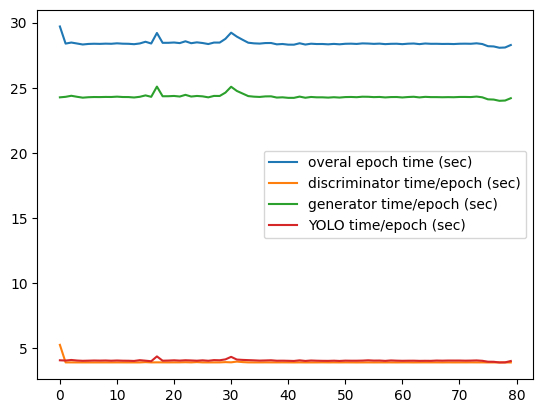

In [15]:
plt.plot(overall_time_epoch, label = 'overal epoch time (sec)')
plt.plot(discr_time_epoch, label = 'discriminator time/epoch (sec)')
plt.plot(gen_time_epoch, label = 'generator time/epoch (sec)')
plt.plot(yolo_time_epoch, label = 'YOLO time/epoch (sec)')
plt.legend()

In [16]:
print("Avg time per epoch (sec): ", np.mean(overall_time_epoch))
print("Avg discriminator time per epoch (sec): ", np.mean(discr_time_epoch))
print("Avg generator time per epoch (sec): ", np.mean(gen_time_epoch))
print("Avg YOLO inference time per epoch (included in the generator time) (sec): ", np.mean(yolo_time_epoch))

Avg time per epoch (sec):  28.426803256587846
Avg discriminator time per epoch (sec):  3.920056752533674
Avg generator time per epoch (sec):  24.313749357763662
Avg YOLO inference time per epoch (included in the generator time) (sec):  4.044951926093927


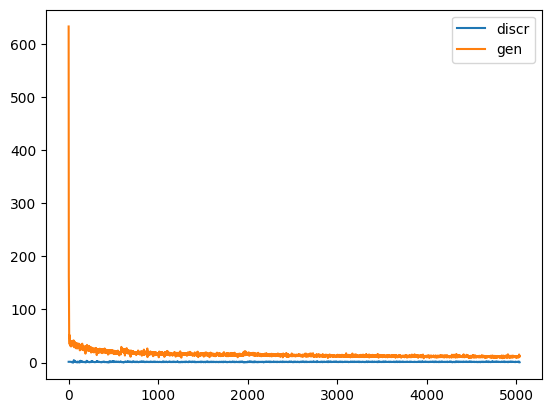

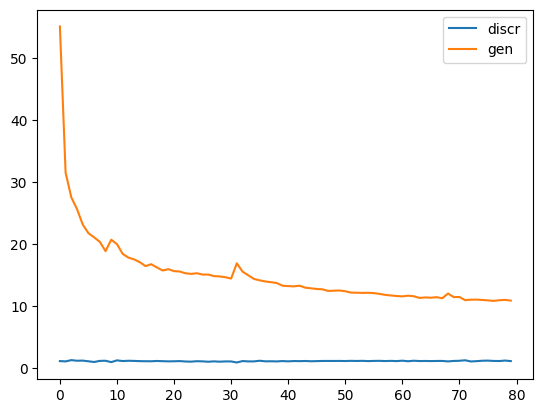

In [17]:
# plot loss graphs
plt.plot(loss_discr_list, label='discr')
plt.plot(loss_gen_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph.png")
plt.show()

plt.plot(loss_discr_by_epoch_list, label='discr')
plt.plot(loss_gen_by_epoch_list, label='gen')
plt.legend()
plt.savefig(f"GANs_training/{run_name}/loss_graph_by_epoch.png")
plt.show()

In [18]:
torch.save(discr_model.state_dict(), f'GANs_training/{run_name}/discriminator_state_dict')
torch.save(gen_model.state_dict(), f'GANs_training/{run_name}/generator_state_dict')

original


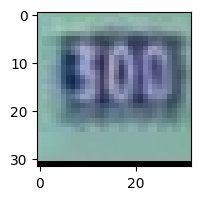

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


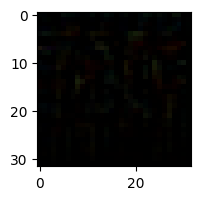

perturbed image


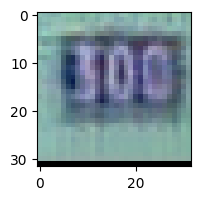

In [19]:
# quick visual check of perturbation

gen_model.eval().cpu()

with torch.no_grad():
    tensor_img = dataset.image_list[0].unsqueeze(0)/256
    perturb = gen_model(tensor_img)
    x_perturbed = tensor_img + perturb
    x_perturbed = torch.clamp(x_perturbed, 0, 1)

tensor_img = tensor_img.squeeze(0).permute(1, 2, 0)
perturb = perturb.squeeze(0).permute(1, 2, 0)
x_perturbed = x_perturbed.squeeze(0).permute(1, 2, 0)

print('original')
plt.subplots(figsize=(2,2))
plt.imshow(tensor_img)
plt.show()
print('perturbation')
plt.subplots(figsize=(2,2))
plt.imshow(perturb)
plt.show()
print('perturbed image')
plt.subplots(figsize=(2,2))
plt.imshow(x_perturbed)
plt.show()

In [20]:
perturb.max()

tensor(0.1186, dtype=torch.float64)

In [21]:
perturb.min()

tensor(-0.1173, dtype=torch.float64)

In [22]:
x_perturbed_shaped = x_perturbed.permute(2, 0, 1).unsqueeze(0)
x_perturbed_reshaped = resize_right.resize(x_perturbed_shaped, out_shape=(1,3,32,32))

In [23]:
tensor_img_shaped = tensor_img.permute(2, 0, 1).unsqueeze(0)
# tensor_img_reshaped = resize_right.resize(tensor_img_shaped, out_shape=(1,3,32,32))

### Summary of Training Procedure

*give summary here to save*

In [29]:
# make sure to save notebook before running this cell
shutil.copyfile('training_google.ipynb', f'GANs_training/{run_name}/training_google.ipynb')

'GANs_training/GANs_training_google12/training_google.ipynb'

In [25]:
save_dir = f'GANs_training/{run_name}/image_samples'
try:
    os.mkdir(save_dir)
except FileExistsError:
    shutil.rmtree(save_dir)
    os.mkdir(save_dir)

In [26]:
# shutil.rmtree(save_dir)

In [27]:
print('images will be saved to', save_dir)

images will be saved to GANs_training/GANs_training_google12/image_samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


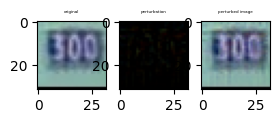

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


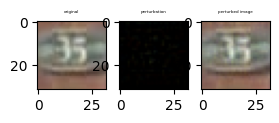

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


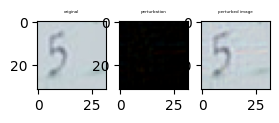

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


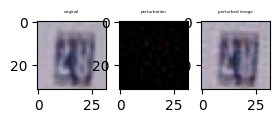

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


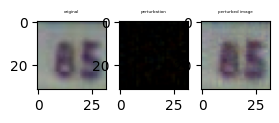

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


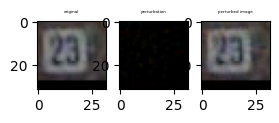

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


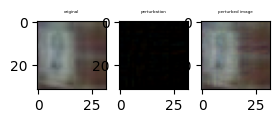

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


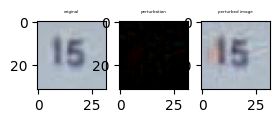

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


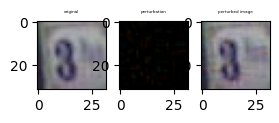

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


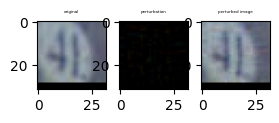

In [28]:
# save original and perturbed images for testing (YOLO inference)

p = []
from torchvision.utils import save_image
gen_model.eval()
for i in range(10):
    with torch.no_grad():
        x = dataset.image_list[i].unsqueeze(0)/256
        tensor_img = x.repeat(1, 1, 1, 1)
        perturb = gen_model(tensor_img)
        p.append(perturb)
        x_perturbed = tensor_img + perturb
        x_perturbed = torch.clamp(x_perturbed, 0, 1)

    tensor_img = tensor_img.squeeze(0).permute(1, 2, 0)
    perturb = perturb.squeeze(0).permute(1, 2, 0)
    x_perturbed = x_perturbed.squeeze(0).permute(1, 2, 0)

    figs, axs = plt.subplots(nrows=1, ncols=3, figsize=(3,9))
    axs[0].imshow(tensor_img)
    axs[0].set_title("original", fontsize=3)
    
    axs[1].imshow(perturb)
    axs[1].set_title('perturbation', fontsize=3)   

    axs[2].imshow(x_perturbed)
    axs[2].set_title('perturbed image', fontsize=3)
    plt.show()
    
    save_image(tensor_img.permute(2, 0, 1), f'{save_dir}/original_{i}.png')
    save_image(perturb.permute(2, 0, 1), f'{save_dir}/perturbation_{i}.png')
    save_image(x_perturbed.permute(2, 0, 1), f'{save_dir}/perturbed_{i}.png')